#imports

In [ ]:
import os
from os import listdir
import numpy as np
import cv2
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import model_from_json
from google.colab.patches import cv2_imshow  
import cv2
import glob
import pandas as pd
from tensorflow.keras.optimizers import RMSprop , Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import CSVLogger
import keras
from matplotlib import pyplot as plt


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#handling the Model

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [ ]:
target_size = (152, 152)

def detectFace(img_path, target_size=(152, 152)):
	
	img = cv2.imread(img_path)
	
  #detect the face in the given image, the output is x,y,w,h
	faces = face_cascade.detectMultiScale(img, 1.3, 5)
	
	if len(faces) > 0:
		x,y,w,h = faces[0]
		
		margin = 0
		x_margin = w * margin / 100
		y_margin = h * margin / 100
		
		if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
			detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
		else:
			detected_face = img[int(y):int(y+h), int(x):int(x+w)]
		
    #resize to 152,,152 which is the expected input size
		detected_face = cv2.resize(detected_face, target_size)
		
    #expand dimension to get the required input (None, 152, 152, 3)
		img_pixels = image.img_to_array(detected_face)
		img_pixels = np.expand_dims(img_pixels, axis = 0)
		
		#normalize in [0, 1]
		img_pixels /= 255 
		
		return img_pixels
	else:
			...
		#raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")
		

#how images are preproccesed

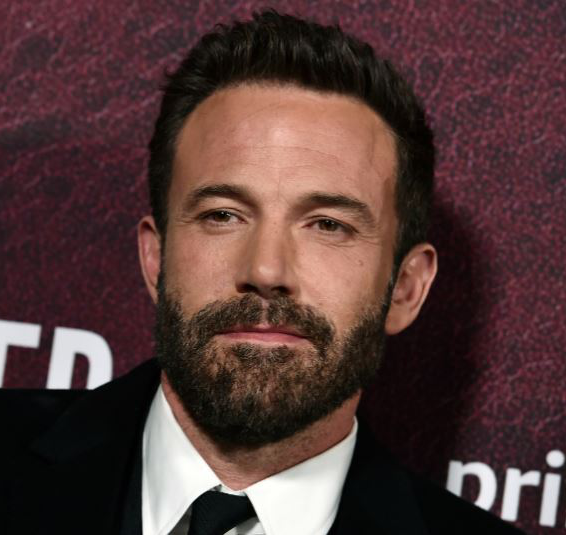

In [ ]:
img_path = ("/content/drive/MyDrive/fbdpface/Capture.png")
cv2_imshow(cv2.imread(img_path))


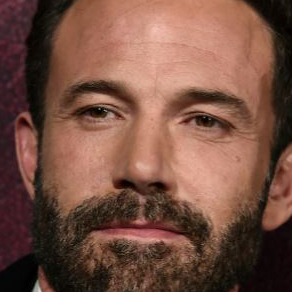

In [ ]:
target_size = (152, 152)


img = cv2.imread(img_path)

#detect the face in the given image, the output is x,y,w,h
faces = face_cascade.detectMultiScale(img, 1.3, 5)

if len(faces) > 0:
  x,y,w,h = faces[0]
  
  margin = 0
  x_margin = w * margin / 100
  y_margin = h * margin / 100
  
  if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
    detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
  else:
    detected_face = img[int(y):int(y+h), int(x):int(x+w)]




cv2_imshow(detected_face)
		
		

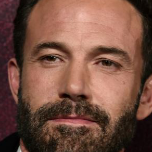

In [ ]:
#resize to 152,,152 which is the expected input size
detected_face = cv2.resize(detected_face, target_size)
cv2_imshow(detected_face)


#metrics

In [ ]:
def l2_normalize(x):
	return x / np.sqrt(np.sum(np.multiply(x, x)))

def findEuclideanDistance(source_representation, test_representation):
	euclidean_distance = source_representation - test_representation
	euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
	euclidean_distance = np.sqrt(euclidean_distance)
	return euclidean_distance


In [ ]:



# CY (2022-03-28 18:56) <---
# Some thoughts:
# - Some custom training should be done, only using pretrained models for prediction will not be enough for thesis
# - Training with small dataset makes only sense in transfer-learning scenarios, 
# because when training from scratch: (little data + complex model -> overfitting)
# - Suggestion: could siamese networks be used for comparing two images (instead of euclidean distance)
# - One possible experimental setup: select two pretrained models. select one big dataset that was not used to train those models.
# Calculate prediction accuracy on this dataset without any fine-tuning.
# Calculate prediction accuracy on this dataset after fine-tuning.
# How the predictions should be made and how accuracy should be calculated -> needs to be determined.
# --->

#preparing the data

In [ ]:
#this function read open the data folder, check for jpg images, detect faces, resize the detected face image 
#and override the file to the original file while keeping track of each folder of data
#after this, the data needs only to be transformed into array, exapnded and scalled
#then its ready to be fed to the model

#with Haar cascade

import cv2
import glob


for filename in glob.glob('/content/drive/MyDrive/fbdpface/Bilal/*.jpg'): # path to your images folder
    print(filename)
    img=cv2.imread(filename)

    target_size = (152, 152)



#detect the face in the given image, the output is x,y,w,h
    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    if len(faces) > 0:
      x,y,w,h = faces[0]
  
      margin = 0
      x_margin = w * margin / 100
      y_margin = h * margin / 100
  
    if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
      detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
    else:
      detected_face = img[int(y):int(y+h), int(x):int(x+w)]


      detected_face = cv2.resize(detected_face, target_size)

       


    
    cv2.imwrite(f'{filename}', detected_face)

In [ ]:
#function to copy the whole data directory before working
from distutils.dir_util import copy_tree
copy_tree("5cel", "edata")

In [ ]:
# same work but with MTCNN

import cv2
import glob
from mtcnn import MTCNN
detector = MTCNN()
mode = 1

for filename in glob.glob('mydata/Val/*/*.JPG'): # path to your images folder
    print(filename)
    img=cv2.imread(filename)

    target_size = (152, 152)



#detect the face in the given image, the output is x,y,w,h
    data=detector.detect_faces(img)

    
    for i, faces in enumerate(data): # iterate through all the faces found
        box=faces['box']  # get the box for each face                
        biggest=0                    
        area = box[3]  * box[2]
        if area>biggest:
            biggest=area
            bbox=box 
    bbox[0]= 0 if bbox[0]<0 else bbox[0]
    bbox[1]= 0 if bbox[1]<0 else bbox[1]
    img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]]
    img = cv2.resize(img, (152,152))

    cv2.imwrite(f'{filename}', img)
    



In [ ]:

# function to take n faces from image with MTCNN
from mtcnn import MTCNN
import cv2
import os
def crop_image(source_dir, dest_dir, mode):

    if os.path.isdir(dest_dir)==False:
        os.mkdir(dest_dir)
    detector = MTCNN()
    source_list=os.listdir(source_dir)
    uncropped_file_list=[]
    for f in source_list:
        f_path=os.path.join(source_dir, f)
        dest_path=os.path.join(dest_dir,f)
        img=cv2.imread(f_path)
        data=detector.detect_faces(img)
        if data ==[]:
            uncropped_file_list.append(f_path)
        else:
            if mode==1:  #detect the box with the largest area
                for i, faces in enumerate(data): # iterate through all the faces found
                    box=faces['box']  # get the box for each face                
                    biggest=0                    
                    area = box[3]  * box[2]
                    if area>biggest:
                        biggest=area
                        bbox=box 
                bbox[0]= 0 if bbox[0]<0 else bbox[0]
                bbox[1]= 0 if bbox[1]<0 else bbox[1]
                img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]]
                img = cv2.resize(img, (152,152))

                cv2.imwrite(dest_path, img)
            else:
                for i, faces in enumerate(data): # iterate through all the faces found
                    box=faces['box']
                    if box !=[]:
                        # return all faces found in the image
                        box[0]= 0 if box[0]<0 else box[0]
                        box[1]= 0 if box[1]<0 else box[1]
                        cropped_img=img[box[1]: box[1]+box[3],box[0]: box[0]+ box[2]]
                        fname=os.path.splitext(f)[0]
                        fext=os.path.splitext(f)[1]
                        fname=fname + str(i) + fext
                        save_path=os.path.join(dest_dir,fname )
                        cv2.imwrite(save_path, cropped_img)  
       
    return uncropped_file_list

In [ ]:
#extracting 2 faces from each image 

import cv2
import glob
for folder in glob.glob('Datafb/Val/*'):
    crop_image(folder , folder , 2 )


In [ ]:
import glob

for filename in glob.glob('/content/drive/MyDrive/fbdpface/myfinaldata/*/*/*.jpg'): # path to your images folder
    print(filename)
    img=cv2.imread(filename)

    target_size = (152, 152)

    img = cv2.resize(img, (152,152))

    cv2.imwrite(f'{filename}', img)
    



#data augmentation

In [ ]:
#creating data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


valdgen = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')



In [ ]:
#classes' names
path = '/content/drive/MyDrive/fbdpface/myfinaldata/train'
dir_list = os.listdir(path)
dir_list.sort()
dir_list

['Abdulhadi',
 'Abdurrahman',
 'Ahmed',
 'Alhamza',
 'Ameer',
 'Baraa',
 'Basak',
 'Bilal',
 'CR7',
 'Eyad',
 'Hamdo',
 'Hamo',
 'Karim',
 'Kurnasan',
 'Mahasin',
 'Melike',
 'Nacho',
 'Nour',
 'Obada',
 'Oubaid',
 'Ram',
 'Safiye',
 'Sarah',
 'Vini',
 'Zeynep_bastik']

In [ ]:
#fitting the traing data

trainingdata = r'/content/drive/MyDrive/fbdpface/myfinaldata/train'

dir_list = os.listdir(trainingdata)
dir_list.sort()


trd = datagen.flow_from_directory( trainingdata, target_size= (152,152) , 
batch_size=15 , class_mode="categorical" ,
 classes= dir_list)
# 345 instead of 292

Found 497 images belonging to 25 classes.


In [ ]:
valdata = r'/content/drive/MyDrive/fbdpface/myfinaldata/val'

dir_list = os.listdir(valdata)
dir_list.sort()


vdt = valdgen.flow_from_directory( valdata, target_size= (152,152) , 
batch_size=15 , class_mode="categorical" ,
 classes= dir_list)
# 345 instead of 292

Found 225 images belonging to 25 classes.


In [ ]:

dir_list

['Abdulhadi',
 'Abdurrahman',
 'Ahmed',
 'Alhamza',
 'Ameer',
 'Baraa',
 'Basak',
 'Bilal',
 'CR7',
 'Eyad',
 'Hamdo',
 'Hamo',
 'Karim',
 'Kurnasan',
 'Mahasin',
 'Melike',
 'Nacho',
 'Nour',
 'Obada',
 'Oubaid',
 'Ram',
 'Safiye',
 'Sarah',
 'Vini',
 'Zeynep_bastik']

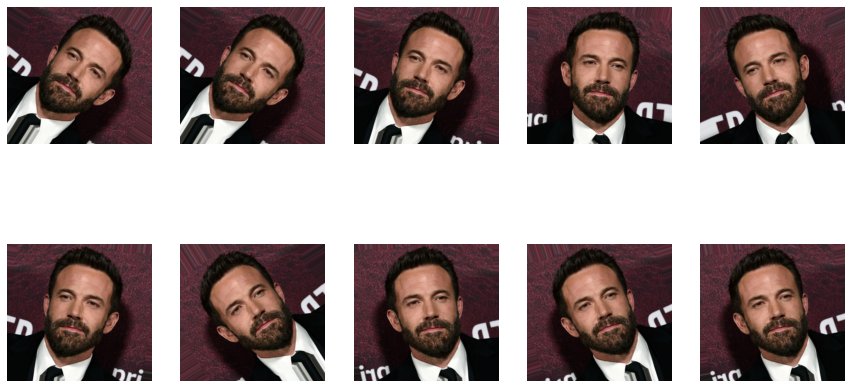

In [ ]:
#output example
img = load_img('/content/drive/MyDrive/fbdpface/Capture.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)

aug_iter = datagen.flow(x, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,8))

# generate batch of images
for i in range(5):
	for j in range(2):
		# convert to unsigned integers
		image = next(aug_iter)[0].astype('uint8')
	
		# plot image
		ax[j][i].imshow(image)
		ax[j][i].axis('off')

#training the model

In [ ]:
# function for adding n trainble layers to the pre traind model
def addlayer( bottommodel , numclasses):
    topmodel = bottommodel.output
    topmodel = (Dense(numclasses, activation='softmax'))(topmodel)
    return topmodel


In [ ]:

def plotfunction(epochesrange):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(epochesrange)

  fig = plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="train accuracy")
  plt.plot(epochs_range, val_acc, label="validataion accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="train loss")
  plt.plot(epochs_range, val_loss, label="validataion loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  fig.tight_layout()
  plt.show()


#model no trandfer learning

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))



NameError: ignored

In [ ]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'D0')>

In [ ]:
#dropping the last softmax layer and replacing it with my 25-nuerons softmax layer
model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)

model.summary()




Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829

In [ ]:
fchead = addlayer(model, 25)

newmodel = Model(inputs = model.input , outputs = fchead)
newmodel.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        282

In [ ]:
#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/notransferL.h5"
csvl = r'/content/drive/MyDrive/fbdpface/notransferL.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop , checkpoint , csv_logger]
#callbacks = [ checkpoint]

In [ ]:
newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.001))

In [ ]:
history = newmodel.fit(

trd,
epochs = 150,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Epoch 1/150
34/34 [==============================] - ETA: 0s - loss: 3.4855 - accuracy: 0.0463
Epoch 1: val_loss improved from inf to 3.21906, saving model to /content/drive/MyDrive/fbdpface/notransferL.h5
34/34 [==============================] - 173s 2s/step - loss: 3.4855 - accuracy: 0.0463 - val_loss: 3.2191 - val_accuracy: 0.0400
Epoch 2/150
34/34 [==============================] - ETA: 0s - loss: 3.2212 - accuracy: 0.0342
Epoch 2: val_loss improved from 3.21906 to 3.21895, saving model to /content/drive/MyDrive/fbdpface/notransferL.h5
34/34 [==============================] - 19s 558ms/step - loss: 3.2212 - accuracy: 0.0342 - val_loss: 3.2190 - val_accuracy: 0.0400
Epoch 3/150
34/34 [==============================] - ETA: 0s - loss: 3.2205 - accuracy: 0.0423
Epoch 3: val_loss did not improve from 3.21895
34/34 [==============================] - 14s 414ms/step - loss: 3.2205 - accuracy: 0.0423 - val_loss: 3.2190 - val_accuracy: 0.0400
Epoch 4/150
34/34 [=============================

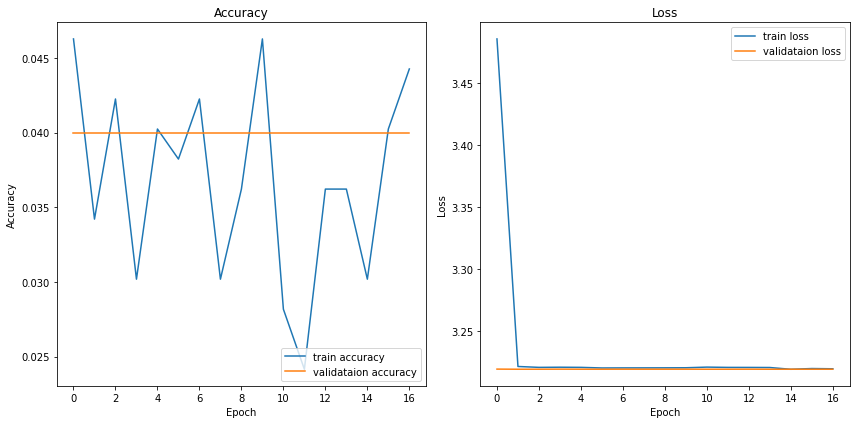

In [ ]:
plotfunction(17)

#first model 1

freezing all layers except for the last 2 + adding a 25neurons layer using Adam optimizer

In [ ]:
#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/testt.h5"
csvl = r'/content/drive/MyDrive/fbdpface/testt.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 10 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop , checkpoint , csv_logger]
#callbacks = [ checkpoint]

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))



In [ ]:
base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")


In [ ]:
model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)


In [ ]:
for layer in model.layers:
  print(layer)



In [ ]:
# Freeze all layers 
for layer in model.layers[:-2]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829

In [ ]:
#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
newmodel.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829

In [ ]:
newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.0001))

In [ ]:
history = newmodel.fit(

trd,
epochs = 100,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

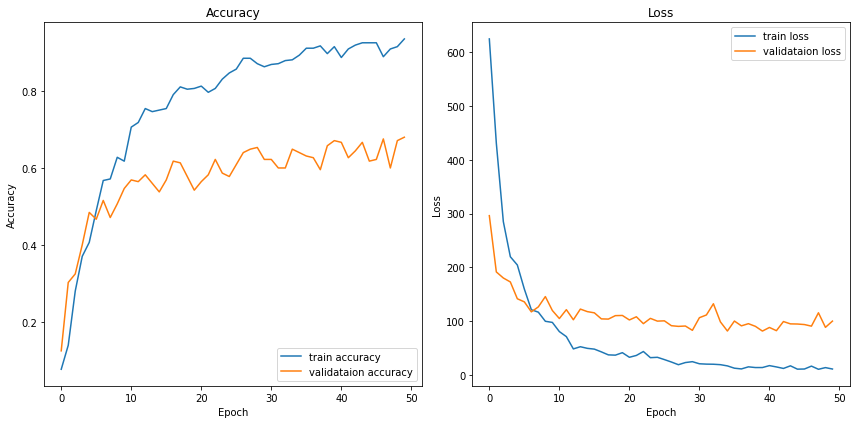

In [ ]:
plotfunction(50)

#2

freezing all layers except for the last 2 + adding a 25neurons layer using RMSprob

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))



In [ ]:
#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/tlalllayers.h5"
csvl = r'/content/drive/MyDrive/fbdpface/tlalllayers.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 10 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  , csv_logger]
#callbacks = [ checkpoint]

In [ ]:
base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
base_model.layers

In [ ]:
model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829

In [ ]:
# Freeze all layers 
for layer in model.layers[:-2]:
  layer.trainable = False


In [ ]:
#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
newmodel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829

In [ ]:
newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =RMSprop(learning_rate = 0.0001))

In [ ]:
history = newmodel.fit(

trd,
epochs = 100,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Epoch 1/100
34/34 [==============================] - 134s 1s/step - loss: 21.6457 - accuracy: 0.8571 - val_loss: 99.7370 - val_accuracy: 0.6311
Epoch 2/100
34/34 [==============================] - 8s 222ms/step - loss: 21.8177 - accuracy: 0.8813 - val_loss: 111.2344 - val_accuracy: 0.5733
Epoch 3/100
34/34 [==============================] - 8s 226ms/step - loss: 16.0891 - accuracy: 0.8773 - val_loss: 90.0327 - val_accuracy: 0.6444
Epoch 4/100
34/34 [==============================] - 7s 212ms/step - loss: 23.5682 - accuracy: 0.8571 - val_loss: 95.4979 - val_accuracy: 0.6178
Epoch 5/100
34/34 [==============================] - 7s 213ms/step - loss: 15.5880 - accuracy: 0.8994 - val_loss: 101.2554 - val_accuracy: 0.6133
Epoch 6/100
34/34 [==============================] - 7s 213ms/step - loss: 18.2574 - accuracy: 0.8793 - val_loss: 93.7696 - val_accuracy: 0.6267
Epoch 7/100
34/34 [==============================] - 7s 213ms/step - loss: 19.6422 - accuracy: 0.8672 - val_loss: 87.9479 - val_a

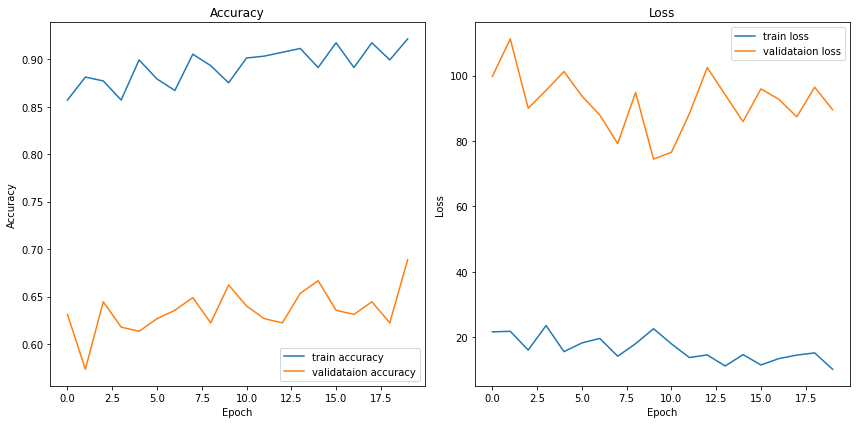

In [ ]:
plotfunction(20)

#3.

freezing all layers except for the last 1 + adding a 25neurons layer

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/451.h5"
csvl = r'/content/drive/MyDrive/fbdpface/451.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
#model.summary()

# Freeze all layers 
for layer in model.layers[:-1]:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.0001))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

34/34 [==============================] - ETA: 0s - loss: 698.6832 - accuracy: 0.0362
Epoch 1: val_loss improved from inf to 339.16547, saving model to /content/drive/MyDrive/fbdpface/451.h5
34/34 [==============================] - 186s 1s/step - loss: 698.6832 - accuracy: 0.0362 - val_loss: 339.1655 - val_accuracy: 0.0533
Epoch 2/500
34/34 [==============================] - ETA: 0s - loss: 609.0217 - accuracy: 0.0523
Epoch 2: val_loss improved from 339.16547 to 294.94513, saving model to /content/drive/MyDrive/fbdpface/451.h5
34/34 [==============================] - 9s 262ms/step - loss: 609.0217 - accuracy: 0.0523 - val_loss: 294.9451 - val_accuracy: 0.0889
Epoch 3/500
34/34 [==============================] - ETA: 0s - loss: 574.6768 - accuracy: 0.0845
Epoch 3: val_loss improved from 294.94513 to 292.29391, saving model to /content/drive/MyDrive/fbdpface/451.h5
34/34 [==============================] - 10s 303ms/step - loss: 574.6768 - accuracy: 0.0845 - val_loss: 292.2939 - val_accura

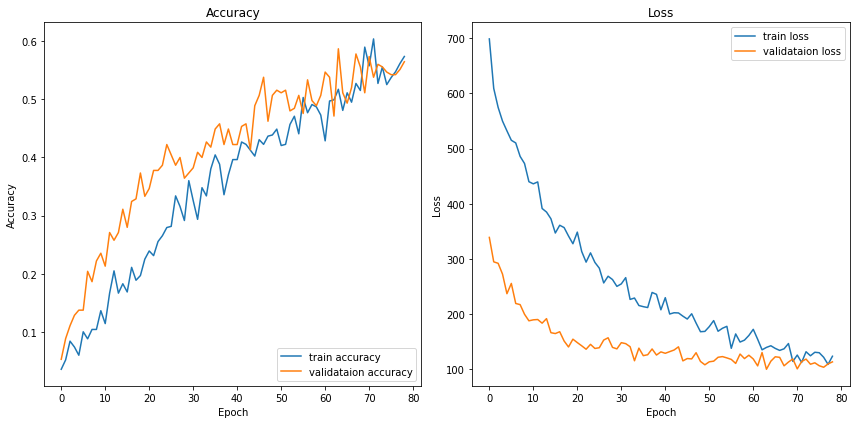

In [ ]:
plotfunction(79)

#4.

freezing all layers except for the last 3 + adding a 25neurons layer

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/44.h5"
csvl = r'/content/drive/MyDrive/fbdpface/44.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
#model.summary()

# Freeze all layers 
for layer in model.layers[:-3]:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.0001))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

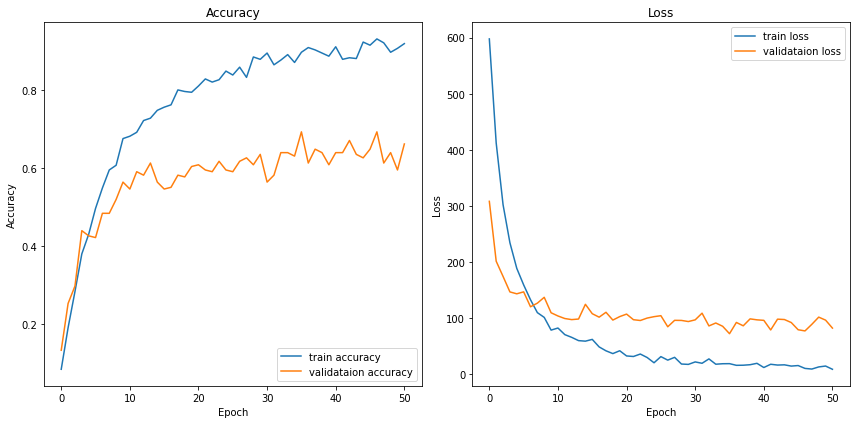

In [ ]:
plotfunction(51)

#5.

freezing all layers except for the last 4 + adding a 25neurons layer

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/55.h5"
csvl = r'/content/drive/MyDrive/fbdpface/55.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
#model.summary()

# Freeze all layers 
for layer in model.layers[:-4]:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.0001))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

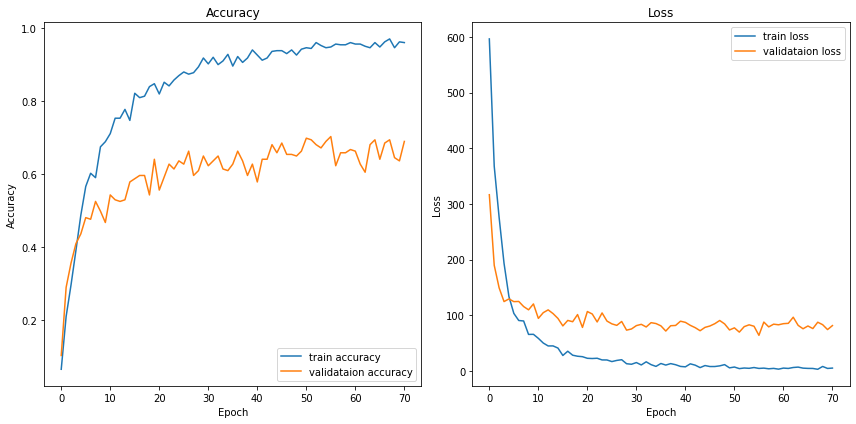

In [ ]:
plotfunction(71)

#6.

freezing all layers

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/66.h5"
csvl = r'/content/drive/MyDrive/fbdpface/66.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
#model.summary()

# Freeze all layers 
for layer in model.layers:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.0001))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

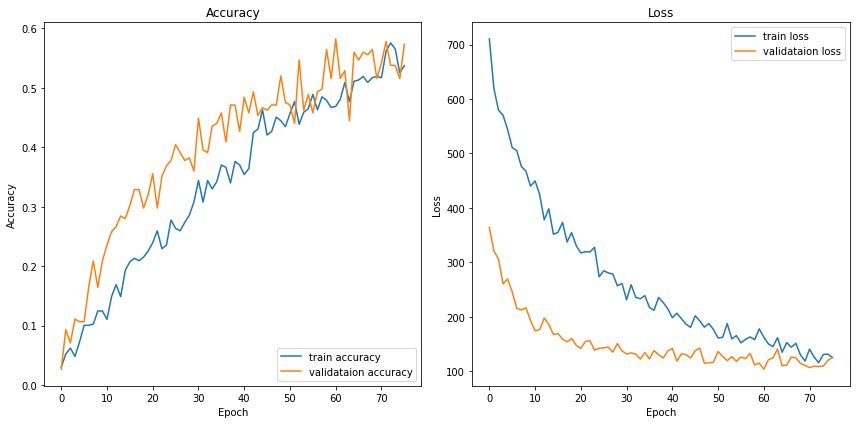

In [ ]:
plotfunction(76)

#7.

smaller learning rate 0.00005

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/77.h5"
csvl = r'/content/drive/MyDrive/fbdpface/77.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
#model.summary()

# Freeze all layers 
for layer in model.layers:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.00005))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

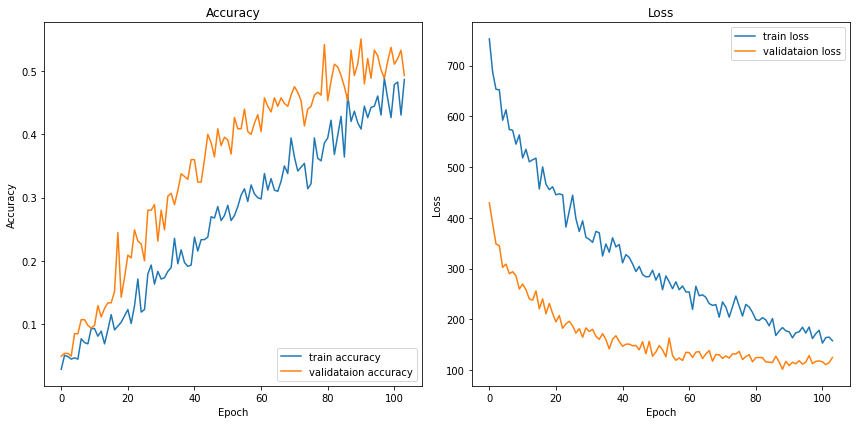

In [ ]:
plotfunction(104)

#8.

smallest learning rate

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/88.h5"
csvl = r'/content/drive/MyDrive/fbdpface/88.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
#model.summary()

# Freeze all layers 
for layer in model.layers:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.00001))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

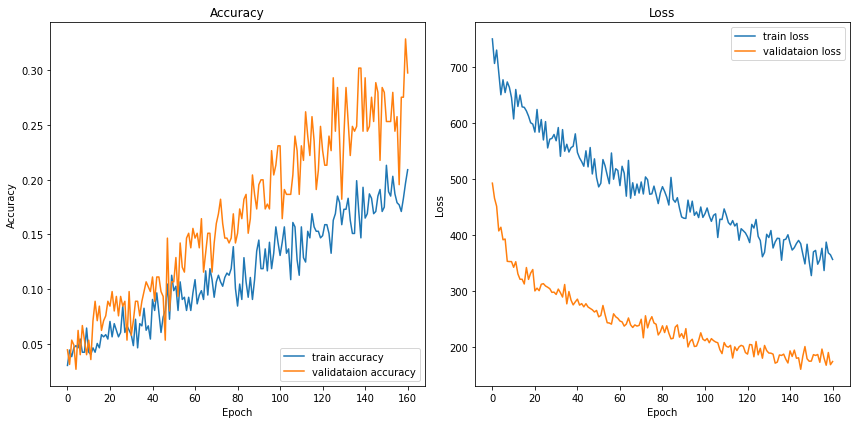

In [ ]:
plotfunction(161)

#9.

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/88.h5"
csvl = r'/content/drive/MyDrive/fbdpface/88.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model.summary()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-2].output)
#model.summary()

# Freeze all layers 
for layer in model.layers:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.001))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

#10.

In [ ]:
for layer in model.layers[:-3]:
  print(layer)

keeping the 8631 layer, freezing all layers exceptfor the last 3

In [ ]:
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))


#callbacks for early stopping and saving the best model

cp = r"/content/drive/MyDrive/fbdpface/99.h5"
csvl = r'/content/drive/MyDrive/fbdpface/99.log'



checkpoint = ModelCheckpoint(cp ,
                             monitor = "val_loss",
                             mode = "min" ,
                            save_best_only = True , verbose = 1)

earlystop = EarlyStopping (monitor = "val_loss" , min_delta = 0 ,
                           patience = 15 , restore_best_weights = True , 
                           verbose = 1)



csv_logger = CSVLogger(csvl, separator=',', append=False)



callbacks = [earlystop  ,checkpoint, csv_logger]
#callbacks = [ checkpoint]

base_model.load_weights("/content/drive/MyDrive/fbdpface/VGGFace2_DeepFace_weights_val-0.9034.h5")
base_model. ()

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-1].output)
#model.summary()

# Freeze all layers 
for layer in model.layers[:-3]:
  layer.trainable = False

#addind one last trainble layer with number of classes depending on my data
# i have 25 differnt classes
fchead = addlayer(model, 25)

#this is the final model
#the last layer is the trainble one
newmodel = Model(inputs = model.input , outputs = fchead)
#newmodel.summary()

newmodel.compile(loss="categorical_crossentropy" , metrics = ["accuracy"] , 
                 optimizer =Adam(learning_rate = 0.0001))


history = newmodel.fit(

trd,
epochs = 500,
validation_data= vdt,
callbacks = callbacks,
)
newmodel.save(cp)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

# all what is under this is to be ignored for now

#plotting 

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

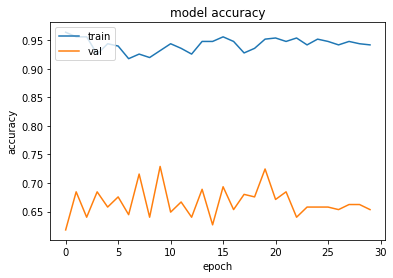

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

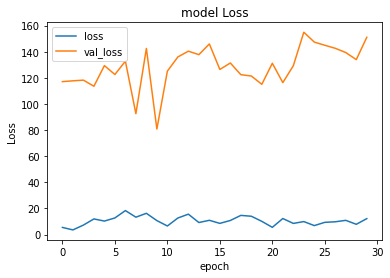

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

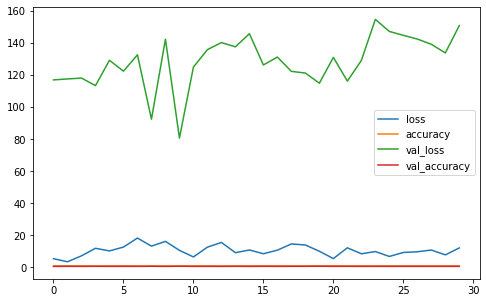

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
max(history.history['accuracy'])


0.9637826681137085

#loading the new model

In [ ]:
from keras.models import load_model
mmodel = load_model(cp)

In [ ]:
mmodel.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829

In [ ]:
log_data = pd.read_csv(csvl, sep=',', engine='python')

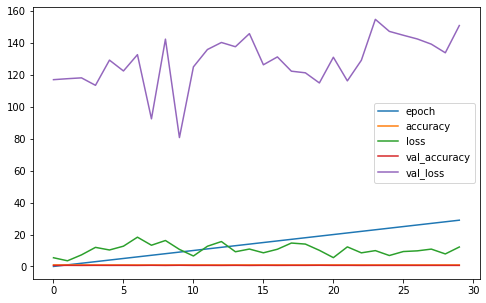

In [ ]:
log_data.plot(figsize=(8,5))
plt.show()

#testing

In [ ]:
CLASSES = dir_list
CLASSES

['Abdulhadi',
 'Abdurrahman',
 'Ahmed',
 'Alhamza',
 'Ameer',
 'Baraa',
 'Basak',
 'Bilal',
 'CR7',
 'Eyad',
 'Hamdo',
 'Hamo',
 'Karim',
 'Kurnasan',
 'Mahasin',
 'Melike',
 'Nacho',
 'Nour',
 'Obada',
 'Oubaid',
 'Ram',
 'Safiye',
 'Sarah',
 'Vini',
 'Zeynep_bastik']

In [ ]:
#function to prepare the images that are already face image and in the shape 152*152
#just converting to array and expanding the dims to None, 152,152,3
from keras.preprocessing.image import img_to_array

def prepareResizedImage(img_path):
	
  img = cv2.imread(img_path)


  detected_face = img
  img_pixels = img_to_array(detected_face)
  img_pixels = np.expand_dims(img_pixels, axis = 0)

  #normalize in [0, 1]
  img_pixels /= 255 

  return img_pixels
	

In [ ]:
path = '/content/drive/MyDrive/fbdpface/myfinaldata/test/*/*.jpg'


truelabels=[]
pred = []
pred.clear()
truelabels.clear()

for filename in glob.glob(path):
    pred.append(CLASSES[np.argmax(mmodel.predict(prepareResizedImage(filename)))])

    filename = filename.replace(path, "").split('/')
    truelabels.append(filename[-2])


In [ ]:
mydict = {'predicted' : pred , 'original' : truelabels}
df =pd.DataFrame(mydict)
df.head(15)

,predicted,original
0,CR7,CR7
1,Zeynep_bastik,Basak
2,Abdurrahman,Abdurrahman
3,Oubaid,Abdulhadi
4,Eyad,Eyad
5,Baraa,Baraa
6,Ahmed,Ahmed
7,Bilal,Bilal
8,Oubaid,Alhamza
9,Baraa,Ameer


In [ ]:
#df[df.apply(lambda x: x['predicted'] != x['original'], axis = 1)]


In [ ]:
#number of false clssified
num = len(df[df.apply(lambda x: x['predicted'] != x['original'], axis = 1)])
print("number of false classified is" , num , "out of" , len(df))

number of false classified is 7 out of 25


In [ ]:
#list of top 3 predictions 
pred1, pred2, pred3 =[] ,[] ,[]
path = '/content/drive/MyDrive/fbdpface/myfinaldata/test/*/*.jpg'
for filename in glob.glob(path):
    #print(CLASSES[np.argmax(mmodel.predict(prepareResizedImage(filename)))])
    a = mmodel.predict(prepareResizedImage(filename))
    a[0].argsort()[-3:][::-1]
    top3 = (a[0].argsort()[-3:][::-1])
    pred1.append(CLASSES[top3[0]])
    pred2.append(CLASSES[top3[1]])
    pred3.append(CLASSES[top3[2]])



In [ ]:
mydict = { 'original' : truelabels , "pred1" : pred1 , "pred2" : pred2 , "pred3" : pred3}
df =pd.DataFrame(mydict)
df.head(15)

,original,pred1,pred2,pred3
0,CR7,CR7,Bilal,Vini
1,Basak,Zeynep_bastik,Basak,CR7
2,Abdurrahman,Nour,Abdurrahman,Ameer
3,Abdulhadi,Abdulhadi,Oubaid,Kurnasan
4,Eyad,Eyad,Nour,Sarah
5,Baraa,Baraa,Bilal,CR7
6,Ahmed,Ahmed,Alhamza,Bilal
7,Bilal,Bilal,Melike,Hamdo
8,Alhamza,Alhamza,Karim,Nacho
9,Ameer,Zeynep_bastik,Sarah,Basak


In [ ]:
df1 = df[df.apply(lambda x: x['pred1'] != x['original'], axis = 1)]
#df1

In [ ]:
df2 = df1[df.apply(lambda x: x['pred2'] != x['original'], axis = 1)]
#df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
df3 = df2[df.apply(lambda x: x['pred3'] != x['original'], axis = 1)]
#df3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
#final report
#number of false clssified
print("number of true classified is (predection with highest prob)" , (len(df) - len(df1)) , "out of" , len(df) , "--------- flase :" , len(df1))
print("predection with 2nd highest prob" , (len(df1) - len(df2)) , " out of ", len(df1)  )
print("predection with 3rd highest prob" , (len(df2) - len(df3)) , " out of ", len(df2)  )
print("false classified(not even in top 3) .......... " , len(df3) , "out of" , len(df))


number of true classified is (predection with highest prob) 17 out of 25 --------- flase : 8
predection with 2nd highest prob 4  out of  8
predection with 3rd highest prob 2  out of  4
false classified(not even in top 3) ..........  2 out of 25


#to be ignored

In [ ]:
#check top n predictions 
path = '/content/drive/MyDrive/fbdpface/resized data/test/Melike/*.jpg'
for filename in glob.glob(path):
    #print(CLASSES[np.argmax(mmodel.predict(prepareResizedImage(filename)))])
    a = mmodel.predict(prepareResizedImage(filename))
    a[0].argsort()[-3:][::-1]
    top3 = (a[0].argsort()[-3:][::-1])
    for i in top3:
      print(CLASSES[i])
    print("-" * 10)

Zeynep_bastik
Basak
Melike
----------
Melike
Basak
Zeynep_bastik
----------
Zeynep_bastik
Melike
Mahasin
----------
Sarah
Zeynep_bastik
Mahasin
----------
Zeynep_bastik
Mahasin
Basak
----------


In [ ]:
path = '/content/drive/MyDrive/fbdpface/resized data/test/*/*.jpg'
import glob



for filename in glob.glob(path):
    filename = filename.replace(path, "").split('/')
    print(filename[-2])


In [ ]:
mmodel.predict(prepareResizedImage("/content/drive/MyDrive/fbdpface/1.jpg"))


array([[7.0822908e-04, 8.5806167e-03, 1.8248413e-04, 1.6424717e-02,
        1.5655626e-03, 3.6170214e-02, 1.2795016e-03, 3.8778245e-02,
        7.1941158e-03, 2.6870950e-03, 2.2877695e-03, 2.0934779e-02,
        6.2260530e-03, 3.9680041e-02, 1.0508450e-03, 9.6265931e-04,
        6.0826510e-01, 3.4088967e-03, 1.0171233e-03, 1.6299374e-01,
        4.3890709e-03, 2.5496205e-02, 1.1526144e-04, 8.3015906e-03,
        1.3001238e-03]], dtype=float32)

In [ ]:
np.argmax(mmodel.predict(prepareResizedImage("/content/drive/MyDrive/fbdpface/1.jpg")))

19

In [ ]:
CLASSES[16]

'Hamdo'

In [ ]:
input_mat = np.array([
    
    [ [-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [1.0], [1.0], [1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [-1.0], [1.0], [-1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [-1.0], [1.0], [-1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [-1.0], [1.0], [-1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [-1.0], [1.0], [-1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [-1.0], [1.0], [-1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [1.0], [1.0], [1.0] , [-1.0], [-1.0], [-1.0],],
    [ [-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1.0] , [-1.0], [-1.0], [-1.0],],
    
])

# we need to give the batch size. 
# here we will just add a dimension at the beginning which makes batch size=1
input_mat = input_mat.reshape((1, 9, 9, 1))

In [ ]:
model = build_model()

out = model.predict(input_mat)
#print(out.reshape(7,7))

In [ ]:
print((out/9).round(decimals=2).reshape(4,4))

[[0.33 0.56 0.33 0.11]
 [0.11 0.33 0.11 0.11]
 [0.11 0.33 0.11 0.11]
 [0.33 1.   0.33 0.11]]


In [ ]:
def build_model():
    input_tensor = Input(shape=(7,7,1))

    x = layers.Conv2D(filters=1, 
                      kernel_size = 3,
                      kernel_initializer=my_filter,
                      strides=1, 
                      activation='relu',
                      padding='valid'
                    ) (input_tensor)
    y = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding="same")(x)
    model = Model(inputs=input_tensor, outputs=x)
    return model

NameError: ignored